In [2]:
# !pip install --upgrade torchvision -qqq
# !pip install -U torch -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [84]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

In [4]:
try:
  from torchinfo import summary
except:
  print(f"couldn't import the module")
  !pip install torchinfo
  from torchinfo import summary

couldn't import the module


In [5]:
try:
  from going_modular import dataset_up,engine,model_builder
except:
  print("clonning the packages from github")
  !git clone https://github.com/nebyu08/torch.git
  !mv torch/going_modular .
  !rm -rf torch
  from going_modular import data_setup,engine

clonning the packages from github
Cloning into 'torch'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (342/342), done.
remote: Total 518 (delta 10), reused 351 (delta 9), pack-reused 165
Receiving objects: 100% (518/518), 81.22 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# get the data

In [8]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [9]:
train_dir=image_path/"train"
test_dir=image_path/"test"

In [85]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# train data loader and test data loader

## handling transforms in transfer learning..using manual transform

In [11]:
from torchvision import transforms

normalize=transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
manual_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])


In [13]:
from going_modular import data_setup

batch_size=32

train_dataloader,test_dataloader,class_names=data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=batch_size
)

In [14]:
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a38b5c791e0>,
 ['pizza', 'steak', 'sushi'])

# lets handle transfer learing using automatic trasnform

In [15]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [16]:
#lets make the transform
automatic_transform=weights.transforms()
automatic_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

# lets load the model

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum


#loadig the weights and model again
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 83.0MB/s]


In [18]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [20]:
summary(model,input_size=(32,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

# freeze the base layers

In [21]:
for params in model.features.parameters():
  params.requires_grad=False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#lets update the classifier layer
model.classifier=nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features=3,
              bias=True)
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
summary(model,input_size=(32,3,224,224),col_names=["input_size","output_size","num_params","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --                        --
│    └─Sequential

# train our model

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
from going_modular.engine import train_model

loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

start_time=timer()

results=train_model(
    model=model,
    train_data=train_dataloader,
    test_data=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device
)
end_time=timer()
print(f"total amount of time taken to train the model is {end_time-start_time:.3f}")

100%|██████████| 5/5 [03:20<00:00, 40.11s/it]

total amount of time taken to train the model is 200.557


In [24]:
print(results)

{'train_loss': [1.1033124551177025, 0.9391874894499779, 0.7610961049795151, 0.760205939412117, 0.6309092044830322], 'train_acc': [1.515625, 2.578125, 3.09375, 2.796875, 3.0625], 'test_loss': [0.8905930916468302, 0.8078705867131551, 0.6431093414624532, 0.5839809576670328, 0.6012211640675863], 'test_acc': [0.3333333333333333, 0.6666666666666666, 1.1111111111111112, 1.1111111111111112, 1.1111111111111112]}


# plot the loss curve

In [25]:
try:
  from helper_function import plot_loss_curves
except:
  with open("helper_function.py","wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

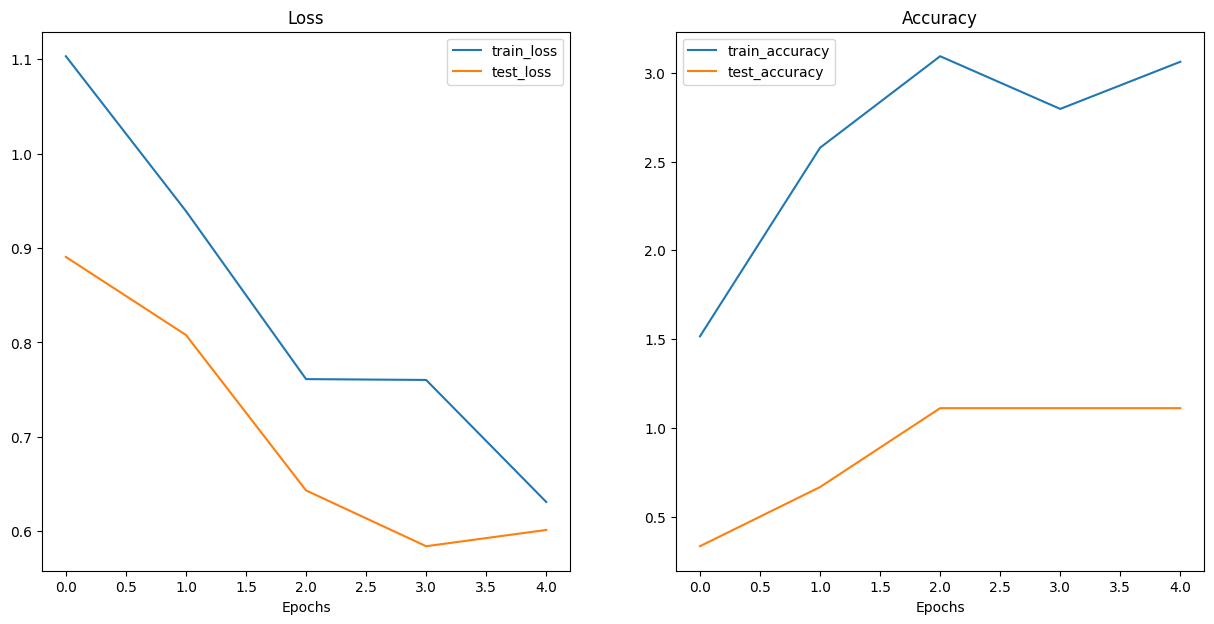

In [26]:
from helper_function import plot_loss_curves
plot_loss_curves(results)

# make predictions on tests:
Note:
* make sure that the image is of the same shape as the input to the model
* on the same device
* data type
* transform the test data/custom data
* dont't forget to normalize

In [69]:
from torchvision import transforms
from PIL import Image
from typing import Tuple,List

def custom_predictions(
    model:nn.Module,
    img_dir:str,
    class_label:List[str],
    img_size:Tuple[int,int]=(224,224),
    device:torch.device=device,
    image_transform:torchvision.transforms=None,
  ):
  #open image
  img=Image.open(img_dir)

  if image_transform is not None:
    transorm=image_transform
  else:
    #make the transform manually
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(img_size),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image=transform(img)
    y_pred_logits=model(transformed_image.unsqueeze(dim=0))
    y_pred=torch.argmax(torch.softmax(y_pred_logits,dim=1),dim=1)
    label_pred=class_names[y_pred]

  plt.figure()
  plt.imshow(img)
  plt.title(f"pred {label_pred} | prob {y_pred_logits.max():.2f}")
  plt.axis("OFF")

In [70]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

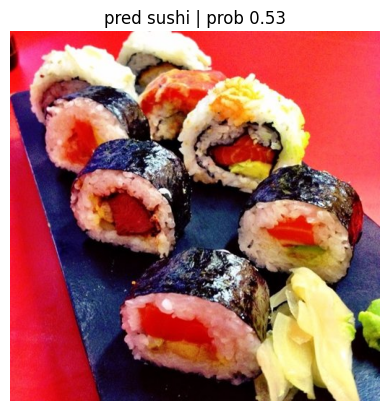

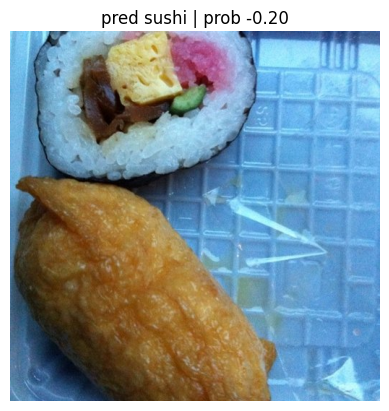

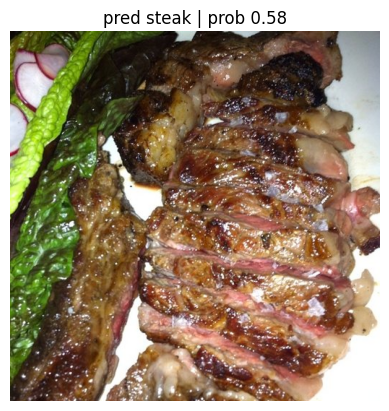

In [74]:
import random
import matplotlib.pyplot as plt

num_samples=3
test_custom_list=list(Path(test_dir).glob("*/*.jpg"))
samples=random.sample(test_custom_list,k=num_samples)

for image_path in samples:
  custom_predictions(
      model=model,
      img_dir=image_path,
      class_label=class_names)

#make predictions on custom "pizza data"

In [82]:
pizza_dad=data_path/"pizza_data.jpeg"

if not pizza_dad.is_file():
  with open(pizza_dad,"wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"file path {pizza_dad} already exists")


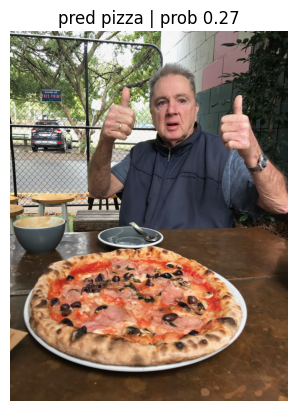

In [83]:
custom_predictions(
    model=model,
    img_dir=pizza_dad,
    class_label=class_names
    )